In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12120)])
  except RuntimeError as e:
    print(e)

In [3]:
import numpy as np
from tensorflow import keras

In [4]:
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from os import listdir, makedirs

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D, concatenate, InputLayer, Lambda
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K
import sys
# from sklearn.model_selection import train_test_split
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [6]:
dog_train = 'data/dog-cat-full-dataset/data/train/dogs/'
cat_train = 'data/dog-cat-full-dataset/data/train/cats/'
dog_test = 'data/dog-cat-full-dataset/data/test/dogs/'
cat_test = 'data/dog-cat-full-dataset/data/test/cats/'
ood = 'data/ood_monkey/'

In [7]:
dog_train_list = listdir(dog_train)
cat_train_list = listdir(cat_train)
dog_test_list = listdir(dog_test)
cat_test_list = listdir(cat_test)
ood_list = listdir(ood)
len(cat_train_list)

10000

In [8]:
np.random.seed(1)
# dog_train_samples=np.random.choice(dog_train_list, 10000)
# cat_train_samples=np.random.choice(cat_train_list, 10000)
# dog_test_samples=np.random.choice(dog_test_list, 250)
# cat_test_samples=np.random.choice(cat_test_list, 250)

dog_train_samples=dog_train_list
cat_train_samples=cat_train_list
dog_test_samples=np.random.choice(dog_test_list, 250)
cat_test_samples=np.random.choice(cat_test_list, 250)

all_train = list(cat_train_samples.copy())
all_train.extend(list(dog_train_samples))
all_test = list(cat_test_samples.copy())
all_test.extend(list(dog_test_samples))
np.random.shuffle(all_test)
np.random.shuffle(all_train)

In [9]:
photos_train = list()
photos_test = list()
train_labels = list()
test_labels = list()
ood_test = list()
# for file in ood_list:
#     photo = load_img(ood+file, target_size=(128, 128))
#     photo = img_to_array(photo)
#     ood_test.append(photo/255.)
for file in all_train:
    
    if file.startswith('cat'):
        folder = cat_train
        train_labels.append(0)
    else:
        folder = dog_train
        train_labels.append(1)
    photo = load_img(folder+file, target_size=(128, 128))
    photo = img_to_array(photo)
    photos_train.append(photo/255.)

for file in all_test:
    if file.startswith('cat'):
        folder = cat_test
        test_labels.append(0)
    else:
        folder = dog_test
        test_labels.append(1)
    photo = load_img(folder+file, target_size=(128, 128))
    photo = img_to_array(photo)
    photos_test.append(photo/255.)


In [10]:
img_rows, img_cols = 128, 128

In [11]:
X_train = photos_train
X_test = photos_test
y_train = train_labels
y_test = test_labels

In [12]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

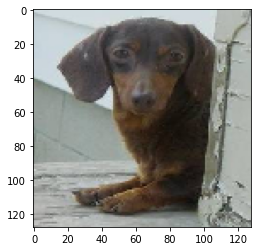

In [13]:
%matplotlib inline
plt.imshow(X_train[0])

In [14]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 50

In [15]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# X_train, X_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)
# Create TF datasets-


print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (20000, 128, 128, 3) & X_test.shape: (500, 128, 128, 3)


In [16]:
y_train, y_test = to_categorical(y_train), to_categorical(y_test)
print(f"y_train.shape: {y_train.shape} & y_test.shape: {y_test.shape}")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train) ).shuffle(4000).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(1000).batch(batch_size = batch_size)

y_train.shape: (20000, 2) & y_test.shape: (500, 2)


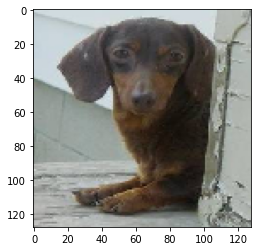

In [17]:
plt.imshow(X_train[0])

In [17]:
class ConvBlock(Model):
    def __init__(
        self, num_filters,
        kernel_size, stride_length,
        pooling_size, pooling_stride,
        padding_type = 'same'
    ):
        super(ConvBlock, self).__init__()
        
        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False,
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.pool = MaxPooling2D(
            pool_size = pooling_size,
            strides = pooling_stride
        )
        
    
    def call(self, x):
        x = tf.keras.activations.relu(self.bn(self.conv1(x)))
        x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        return x

In [18]:
class Conv6_Encoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Encoder, self).__init__()

        self.latent_dim = latent_dim
        
        self.conv_block1 = ConvBlock(
            num_filters = 64, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.conv_block2 = ConvBlock(
            num_filters = 128, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )
        
        self.conv_block3 = ConvBlock(
            num_filters = 256, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.flatten = Flatten()
        
        self.output_layer = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
    
    def call(self, x):
        x1 = x[0]
        x2 = x[1]
        o = self.conv_block1(x1)
        o = self.conv_block2(o)
        o = self.conv_block3(o)
#         res_shape = x.shape
        o = self.flatten(o)
        
        o = K.concatenate([o,x2], axis=-1)
        o = tf.keras.activations.relu(self.bn(self.output_layer(o)))
        return o, x2
    
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x1 = Input(shape = (128,128,3))
        x2 = Input(shape = (2,))
        return Model(inputs = [x1,x2], outputs = self.call([x1,x2]))
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_block1(x)
        print(f"conv_block1.shape: {x.shape}")
        x = self.conv_block2(x)
        print(f"conv_block2.shape: {x.shape}")
        x = self.conv_block3(x)
        print(f"conv_block3.shape: {x.shape}")
        x = self.flatten(x)
        print(f"flattened shape: {x.shape}")
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        print(f"Encoder output shape: {x.shape}")
        '''
        Input shape: (64, 32, 32, 3)
        conv_block1.shape: (64, 14, 14, 64)
        conv_block2.shape: (64, 5, 5, 128)
        conv_block3.shape: (64, 2, 2, 256)
        flattened shape: (64, 1024)
        Encoder output shape: (64, 100)
        '''
        
        return None

In [19]:
class Conv6_Decoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Decoder, self).__init__()

        self.latent_dim = latent_dim
#         self.inp_layer = InputLayer(input_shape = self.latent_dim+10)
        
        print('In decoder')
        self.dense0 = Dense(
            units = self.latent_dim+2, activation = None
            )
        self.bn0 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.dense = Dense(
            units = 1024, activation = None
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.dense2 = Dense(
            units = 16 * 16 * 256, activation = None
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.reshape = Reshape((16, 16, 256))
        
        self.conv_transpose_layer1 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
       
        self.conv_transpose_layer2 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv_transpose_layer3 =  Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv_transpose_layer4 = Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer5 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
       
        self.conv_transpose_layer6 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn8 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.final_conv_layer = Conv2DTranspose(
            filters = 3, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
    
    def call(self, X):
#         X = self.inp_layer(X)
        x1 = X[0]
        x2 = X[1]
        X = K.concatenate([x1,x2])
        X = tf.keras.activations.relu(self.bn0(self.dense0(X)))
        X = tf.keras.activations.relu(self.bn(self.dense(X)))
        X = tf.keras.activations.relu(self.bn2(self.dense2(X)))
        X = self.reshape(X)
        X = tf.keras.activations.relu(self.bn3(self.conv_transpose_layer1(X)))
        X = tf.keras.activations.relu(self.bn4(self.conv_transpose_layer2(X)))
        X = tf.keras.activations.relu(self.bn5(self.conv_transpose_layer3(X)))
        X = tf.keras.activations.relu(self.bn6(self.conv_transpose_layer4(X)))
        X = tf.keras.activations.relu(self.bn7(self.conv_transpose_layer5(X)))
        X = tf.keras.activations.relu(self.bn8(self.conv_transpose_layer6(X)))
        # X = tf.keras.activations.sigmoid(self.final_conv_layer(X))
        X = self.final_conv_layer(X)

        return X
        
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x1 = Input(shape = (100))
        x2 = Input(shape=(2,))
        return Model(inputs = [x1,x2], outputs = self.call([x1,x2]))
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn0(self.dense0(x)))
        print(f"first dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn(self.dense(x)))
        print(f"second dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        print(f"third dense layer shape: {x.shape}")
        x = self.reshape(x)
        print(f"reshape: {x.shape}")
        x = tf.nn.relu(self.bn3(self.conv_transpose_layer1(x)))
        print(f"conv transpose layer1 shape: {x.shape}")
        x = tf.nn.relu(self.bn4(self.conv_transpose_layer2(x)))
        print(f"conv transpose layer2 shape: {x.shape}")
        x = tf.nn.relu(self.bn5(self.conv_transpose_layer3(x)))
        print(f"conv transpose layer3 shape: {x.shape}")
        x = tf.nn.relu(self.bn6(self.conv_transpose_layer4(x)))
        print(f"conv transpose layer4 shape: {x.shape}")
        x = tf.nn.relu(self.bn7(self.conv_transpose_layer5(x)))
        print(f"conv transpose layer5 shape: {x.shape}")
        x = tf.nn.relu(self.bn8(self.conv_transpose_layer6(x)))
        print(f"conv transpose layer6 shape: {x.shape}")
        x = self.final_conv_layer(x)
        print(f"Decoder output shape: {x.shape}")
        
        '''
        Input shape: (64, 100)
        first dense layer shape: (64, 100)
        second dense layer shape: (64, 1024)
        third dense layer shape: (64, 4096)
        reshape: (64, 4, 4, 256)
        conv transpose layer1 shape: (64, 8, 8, 256)
        conv transpose layer2 shape: (64, 8, 8, 256)
        conv transpose layer3 shape: (64, 16, 16, 128)
        conv transpose layer4 shape: (64, 16, 16, 128)
        conv transpose layer5 shape: (64, 32, 32, 64)
        conv transpose layer6 shape: (64, 32, 32, 64)
        Decoder output shape: (64, 32, 32, 3)
        '''
        
        return None
        

In [20]:
class Sampling(tf.keras.layers.Layer):
    """
    Create a sampling layer.
    Uses (mu, log_var) to sample latent vector 'z'.
    """
    def call(self, mu, log_var):
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate standard 
        # Gaussian distribution-
        epsilon = tf.keras.backend.random_normal(
            shape = (batch, dim), mean = 0.0,
            stddev = 1.0
        )
        z = mu + (tf.exp(0.5 * log_var) * epsilon)
        return z



In [21]:
class VAE(Model):
    def __init__(self, latent_space = 100):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        self.encoder = Conv6_Encoder(latent_dim = self.latent_space)
        self.decoder = Conv6_Decoder(latent_dim = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None, name='mu')
        self.log_var = Dense(units = self.latent_space, activation = None, name='logvar')


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5) + mu)
        
    
    def call(self, x):
        latent, label = self.encoder(x)
        # x.shape: (batch_size, 100)
        mu = self.mu(latent)
        log_var = self.log_var(latent)
        # z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        z = Sampling()(mu, log_var)
        
        
        
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 100), log_var.shape: (batch_size, 100) & z.shape: (batch_size, 100)
        '''
        x = tf.keras.activations.sigmoid(self.decoder([z, label]))
        return x, mu, log_var, z
    
    
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x1 = Input(shape = (128,128,3))
        x2 = Input(shape = (2,))
        return Model(inputs = [x1,x2], outputs = self.call([x1,x2]))

In [22]:
# Initialize VAE model-
model = VAE(latent_space = 100)
model.model().summary()

In decoder
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 conv6__encoder (Conv6_Encoder)  ((None, 100),       7702396     ['input_1[0][0]',                
                                 (None, 2))                       'input_2[0][0]']                
                                                                                   

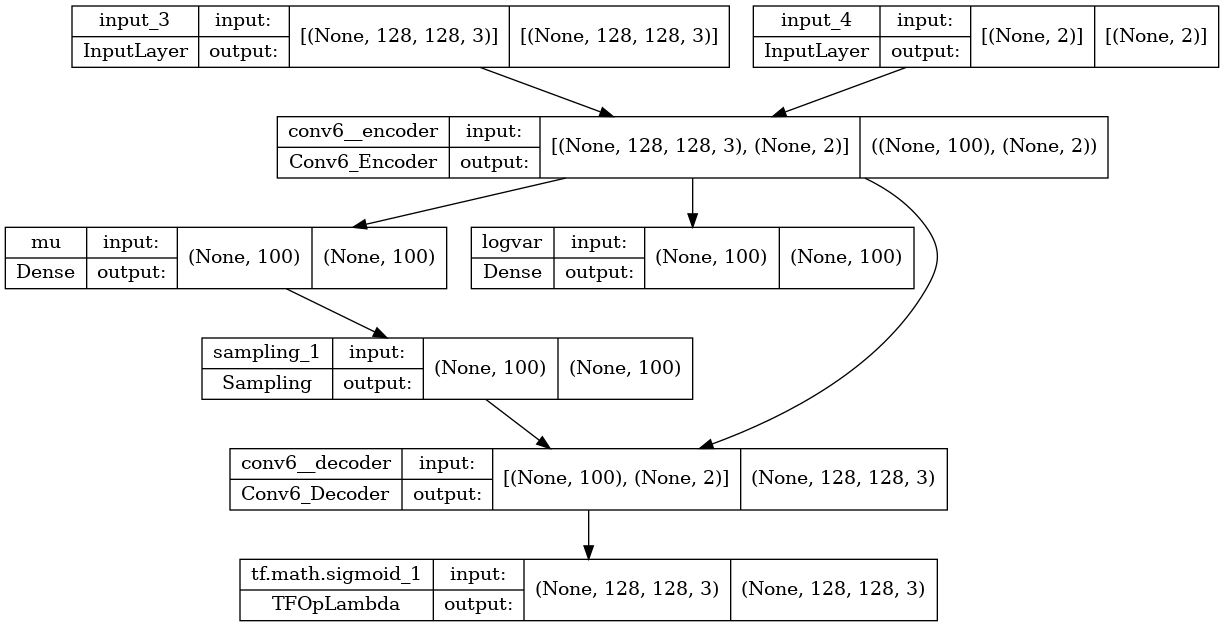

In [23]:
from tensorflow.keras.utils import plot_model 
plot_model(model.model(), show_shapes=True, to_file='vgg_dogcat_vae_model.png')

In [24]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [25]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):
    
    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
#             tf.keras.losses.mean_squared_error(data, reconstruction),
#             axis = (1, 2)
            )
        )
    
    # KL-divergence loss-    
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(
        tf.reduce_sum(
            kl_loss,
            axis = 1
        )
    )

    total_loss = (recon_loss * alpha) + kl_loss
    
    return total_loss, recon_loss, kl_loss
    

In [26]:
@tf.function
def train_one_step(model, optimizer, data, alpha):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var, z = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


@tf.function
def test_step(model, optimizer, data, alpha):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var, z = model(data)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = data_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )
    
    return total_loss, recon_loss, kl_loss

In [27]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 10

# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [29]:
for epoch in range(1, num_epochs + 1):
    """
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    """

    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0
    
    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = list(data), alpha = alpha
        )
        
        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()
    
    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)
        
        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()
    
    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }
    
    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )

epoch = 1; total train loss = 31829701.1797, train recon loss = 3172863.2725, train kl loss = 101068.4802; total val loss = 801042.5469, val recon loss = 79831.0342 & val kl loss = 2732.1957
epoch = 2; total train loss = 31367277.5000, train recon loss = 3126241.7188, train kl loss = 104860.2424; total val loss = 788353.4844, val recon loss = 78563.9189 & val kl loss = 2714.2826
epoch = 3; total train loss = 31129826.3984, train recon loss = 3102673.7812, train kl loss = 103088.6421; total val loss = 785875.0781, val recon loss = 78335.0371 & val kl loss = 2524.7134
epoch = 4; total train loss = 31008333.4219, train recon loss = 3090980.2119, train kl loss = 98531.1885; total val loss = 781131.8125, val recon loss = 77855.6865 & val kl loss = 2574.9611
epoch = 5; total train loss = 30911994.0547, train recon loss = 3081544.7363, train kl loss = 96546.6774; total val loss = 780201.5234, val recon loss = 77771.9131 & val kl loss = 2482.3940
epoch = 6; total train loss = 30846940.6953, tr

epoch = 44; total train loss = 29764949.4062, train recon loss = 2966823.9385, train kl loss = 96709.9174; total val loss = 792531.3750, val recon loss = 79003.0957 & val kl loss = 2500.4131
epoch = 45; total train loss = 29743152.3516, train recon loss = 2964562.9814, train kl loss = 97522.5514; total val loss = 794407.6797, val recon loss = 79187.6172 & val kl loss = 2531.5221
epoch = 46; total train loss = 29701187.4531, train recon loss = 2960363.1436, train kl loss = 97555.9020; total val loss = 794647.2422, val recon loss = 79212.2041 & val kl loss = 2525.1977
epoch = 47; total train loss = 29659758.4375, train recon loss = 2956180.9922, train kl loss = 97948.4800; total val loss = 794811.3438, val recon loss = 79228.3086 & val kl loss = 2528.2587
epoch = 48; total train loss = 29627128.9922, train recon loss = 2952883.4219, train kl loss = 98294.7383; total val loss = 795847.6094, val recon loss = 79329.5078 & val kl loss = 2552.5273
epoch = 49; total train loss = 29585007.3984,

In [19]:
# model = keras.models.load_model('vgg_dogcat_250')

In [25]:
# model.compile()
# model.encoder.summary()

Model: "conv6__encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block (ConvBlock)      multiple                  39104     
                                                                 
 conv_block_1 (ConvBlock)    multiple                  222208    
                                                                 
 conv_block_2 (ConvBlock)    multiple                  886784    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  6553900   
                                                                 
 batch_normalization_6 (Batc  multiple                 400       
 hNormalization)                                                 
                                                    

In [26]:
x_data = X_test[:2000]
y_data = y_test[:2000]
y_data.shape

(500, 2)

In [27]:
y_data[145]

array([0., 1.], dtype=float32)

In [28]:
%matplotlib inline
j = 52
x, mu, log_var, z = model.predict([x_data[j].reshape(1,128,128,3), y_data[j].reshape(1,2)])
plt.imshow(x_data[j])

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "vae" (type VAE).
    
    Could not find matching concrete function to call loaded from the SavedModel. Got:
      Positional arguments (2 total):
        * (<tf.Tensor 'x:0' shape=(None, 128, 128, 3) dtype=float32>, <tf.Tensor 'x_1:0' shape=(None, 2) dtype=float32>)
        * False
      Keyword arguments: {}
    
     Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='x/0'), TensorSpec(shape=(None, 2), dtype=tf.float32, name='x/1')]
        * False
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='x/0'), TensorSpec(shape=(None, 2), dtype=tf.float32, name='x/1')]
        * True
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_1'), TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_2')]
        * False
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_1'), TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_2')]
        * True
      Keyword arguments: {}
    
    Call arguments received:
      • args=(('tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)', 'tf.Tensor(shape=(None, 2), dtype=float32)'),)
      • kwargs={'training': 'False'}


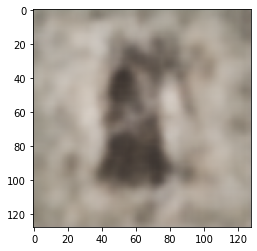

In [33]:
plt.imshow(x[0])

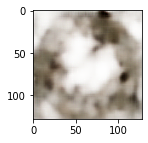

In [34]:
from PIL import Image, ImageEnhance
z_ex = np.random.normal(0, 1, (1,100))
y = y_data[145].reshape(1,2)
z_ex.shape
out = tf.keras.activations.sigmoid(model.decoder([z_ex, y]))
im = tf.keras.preprocessing.image.array_to_img(out[0])
enhancer = ImageEnhance.Sharpness(im)

factor = 5
im_s_1 = enhancer.enhance(factor)

plt.figure(figsize=(2,2))
plt.imshow(im_s_1)

In [36]:
recon = list()
tot = list()
kl = list()
for i in range(50):
    recon.append(training_metrics[i+1]['recon_loss'])
    tot.append(training_metrics[i+1]['total_loss'])
    kl.append(training_metrics[i+1]['kl_loss'])



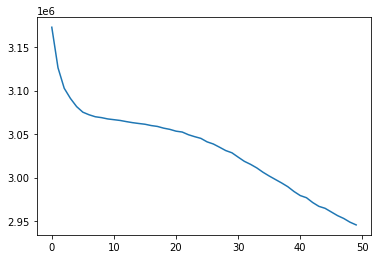

In [37]:
plt.plot(recon)

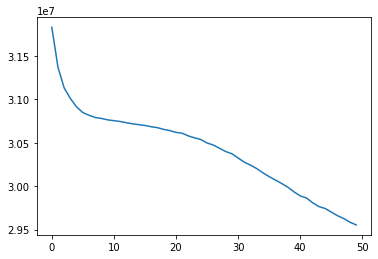

In [38]:
plt.plot(tot)

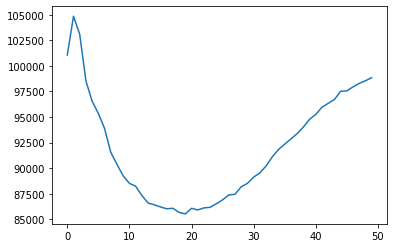

In [39]:
plt.plot(kl)

In [40]:
for file in ood_list:
    photo = load_img(ood+file, target_size=(128, 128))
    photo = img_to_array(photo)
    ood_test.append(photo/255.)

In [41]:
ood_test = np.asarray(ood_test)

In [42]:
x_od, mu_od, logvar_od, z_od = model.predict([ood_test, y_data[:250]])

In [43]:
kl_od = -0.5 * (1 + logvar_od - tf.square(mu_od) - tf.exp(logvar_od))

In [44]:
kl_od_avg = tf.reduce_sum(
            kl_od,
            axis = 1
        )

In [45]:
kl_od_avg

<tf.Tensor: shape=(250,), dtype=float32, numpy=
array([330.40622, 311.4671 , 401.50262, 294.64594, 249.74854, 280.55786,
       353.88727, 328.63702, 309.2896 , 238.1694 , 292.82043, 371.4323 ,
       280.54163, 466.0064 , 233.77464, 320.9585 , 362.41388, 398.02258,
       316.49707, 388.54883, 398.98395, 347.32553, 272.2498 , 315.13   ,
       271.0868 , 402.4369 , 322.72296, 304.61203, 235.72751, 291.8897 ,
       481.82806, 346.6115 , 330.8322 , 416.69357, 261.18695, 436.86694,
       303.949  , 251.42538, 239.53342, 457.9801 , 288.3762 , 256.39697,
       265.9301 , 351.59277, 277.09155, 325.04352, 283.40027, 306.15137,
       414.13458, 272.09705, 344.72168, 185.08105, 305.90845, 335.85803,
       268.49292, 293.22644, 273.31445, 328.15024, 310.59967, 269.96045,
       390.31494, 275.14615, 354.90942, 236.0888 , 296.32742, 301.15363,
       283.40454, 386.35645, 258.31418, 365.33145, 374.2837 , 313.98206,
       280.08673, 243.24707, 321.56616, 263.78406, 282.0905 , 326.83807,
   

In [46]:
x, mu, logvar, z = model.predict([x_data[:250], y_data[:250]])

In [47]:
kl = -0.5 * (1 + logvar - tf.square(mu) - tf.exp(logvar))

In [48]:
kl_avg = tf.reduce_sum(
            kl,
            axis = 1
        )

(array([ 5., 22., 61., 62., 44., 24., 13., 10.,  7.,  2.]),
 array([151.22273, 193.53296, 235.8432 , 278.15344, 320.46368, 362.7739 ,
        405.08414, 447.39438, 489.7046 , 532.01483, 574.3251 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

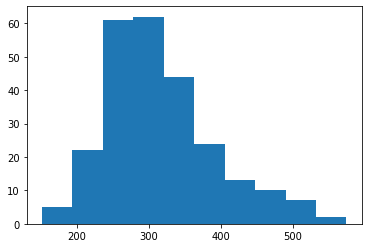

In [49]:
counts, bins = np.histogram(kl_avg)
plt.hist(bins[:-1], bins, weights=counts)

(array([ 3., 64., 65., 64., 31., 10., 11.,  1.,  0.,  1.]),
 array([185.08105, 232.29938, 279.5177 , 326.736  , 373.9543 , 421.17264,
        468.39096, 515.60925, 562.8276 , 610.0459 , 657.2642 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

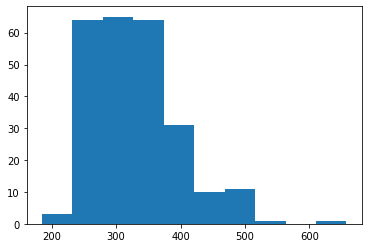

In [50]:
counts, bins = np.histogram(kl_od_avg)
plt.hist(bins[:-1], bins, weights=counts)

In [51]:
model

In [52]:
model.save('vgg_dogcat_250')

INFO:tensorflow:Assets written to: vgg_dogcat_250/assets
